In [1]:
import numpy as np

class MySystem:
    def __init__(self, x, y, angle, dt=0.1):
        self.x, self.y, self.angle, self.dt = x, y, angle, dt

    def evolve(self):
        self.x += np.cos(self.angle) * self.dt
        self.y += np.sin(self.angle) * self.dt

    def update(self, d_angle):
        self.angle += d_angle * np.pi / 180

    def error(self):
        return self.y

In [2]:
class Pid:
    error0=0
    integral=0

    def __init__(self, ke, kd, ki, dt=0.1):
        self.ke, self.kd, self.ki, self.dt = ke, kd, ki, dt

    def correction(self, error):
        d_error = (error - self.error0) / self.dt
        self.error0 = error
        self.integral += error * self.dt
        return - (self.ke * error + self.kd * d_error + self.ki * self.integral)

In [8]:
import sys
sys.path.append("../../dist/bin/libs/wrappers/python")  # set to correct path for module"
import rtbot
import rtbot as rb
from rtbot import operators as op

class Pid_rb:    
    def __init__(self, ke, kd, ki, dt=0.1):
        self.program = rb.Program(
            title = "test",
            author = "user",
            license = "MIT",
        ) \
        .addOperator(op.Input("in1")) \
        .addOperator(op.Scale("ke", -ke)) \
        .addOperator(op.Scale("kd", -kd/dt)) \
        .addOperator(op.Scale("ki", -ki*dt)) \
        .addOperator(op.Difference("derivative")) \
        .addOperator(op.CumulativeSum("integral")) \
        .addOperator(op.Plus("sum_pd")) \
        .addOperator(op.Plus("sum_pdi")) \
        .addOperator(op.Output("out1")) \
        .addConnection("in1", "ke").addConnection("ke", "sum_pd", "o1", "i1").addConnection("sum_pd", "sum_pdi", "o1", "i1").addConnection("sum_pdi", "out1") \
        .addConnection("in1", "derivative").addConnection("derivative", "kd").addConnection("kd", "sum_pd", "o1", "i2") \
        .addConnection("in1", "integral").addConnection("integral", "ki").addConnection("ki", "sum_pdi", "o1", "i2")
        
        self.pid = rb.Run(self.program)
        self.pid.receive([0,0])
        self.t=0
    
    def correction(self, error):
        self.t += 1
        return self.pid.receive([self.t, error])['out1:o1']['value'][0]

In [9]:
def test_pid(pid):
    sys = MySystem(x=0, y=1, angle=0)
    out = []
    for i in range(2000):
        sys.evolve()
        correction = pid.correction(sys.error())
        sys.update(correction)
        out += [[sys.x, sys.y, sys.angle]]
    return np.array(out)

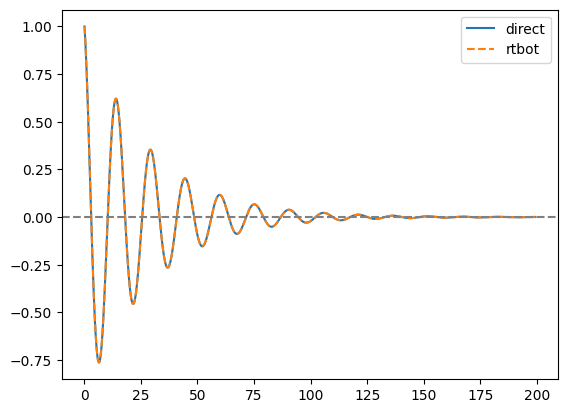

In [7]:
import matplotlib.pyplot as plt

out1 = test_pid(Pid(1,1,1/10))
out2 = test_pid(Pid_rb(1,1,1/10))
plt.plot(out1[:,0], out1[:,1], label='direct')
plt.plot(out2[:,0], out2[:,1], '--', label='rtbot')
plt.axhline(y=0, color='gray', linestyle='--')
plt.legend()

In [14]:
import base64
from IPython.display import Image, display

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm(Pid_rb(1,1,0.3).program.toMermaidJs())